In [121]:
# imports
import pickle
import numpy as np
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
from torch import nn
from braindecode.datasets.sleep_physionet import SleepPhysionet
from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.windowers import crea
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018
from braindecode import EEGClassifier
from braindecode.datautil.preprocess import zscore
from braindecode.samplers.ssl import RelativePositioningSampler

import relative_positioning as rp
import contrastive_net as cn

from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import helper_funcs as hf


# ----

from skorch.utils import to_tensor

ImportError: cannot import name 'crea' from 'braindecode.datautil.windowers' (/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/braindecode/braindecode/datautil/windowers.py)

In [ ]:

# constants
random_state = 87
n_jobs = 1
window_size_s = 30
sfreq = 100

# define pre-training dataset
dataset = SleepPhysionet(
    subject_ids=[0,1,2,3,4,5],
    recording_ids=[1]
)


# sample data for which we are trying to generate predictions of the input data using a part of the SSL pre-trained model
path_to_sample = "/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/sleep_staging_dataset/"

# input test
X = mne.io.read_raw_fif(path_to_sample+"0-raw.fif")

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/maligan/mne_data

In [ ]:
# dataset involves mutliple datasets - different subjects
print(len(dataset.datasets[0]))
print(len(X))

X.datasets = X
print(len(X.datasets))

2508001
2508001
2508001


In [ ]:
# preprocessing

preprocessors = [
    Preprocessor(lambda x: x * 1e6),
    Preprocessor('filter', l_freq=None, h_freq=30, n_jobs=n_jobs)
]
preprocess(dataset, preprocessors)


# Create windows
window_size_samples = window_size_s * sfreq

mapping = {  # We merge stages 3 and 4 following AASM standards.
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,
    'Sleep stage R': 4
}

# define windows
windows_dataset = create_windows_from_events(
    dataset, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples, preload=True, mapping=mapping)

# preprocess chanel-wise normalization
preprocess(windows_dataset, [Preprocessor(zscore)])


Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...


/home/maligan/Documents/VU/Year_2/M.Sc._Thesis_[X_400285]/my_thesis/code/braindecode_code/braindecode/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)

Reading 0 ... 3060000  =      0.000 

/home/maligan/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function zscore is deprecated; will be removed in 0.7.0. Use sklearn.preprocessing.scale instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# from braindecode.datautil.preprocess import preprocess_raw

### input test

# preprocess(X, preprocessors)
# X_windows_dataset = create_windows_from_events(
#     X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
#     window_size_samples=window_size_samples,
#     window_stride_samples=window_size_samples, preload=True, mapping=mapping)
# preprocess(X_windows_dataset, [Preprocessor(zscore)])

X = SleepPhysionet(
    subject_ids=[0],
    recording_ids=[1]
)
X_windowed = create_windows_from_events(
    X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
    window_size_samples=window_size_samples,
    window_stride_samples=window_size_samples)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/maligan/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
837 matching events found
No baseline correction applied
0 projection items activated
Loading data for 837 events and 3000 original time points ...
0 bad epochs dropped


In [ ]:
# Splitting train, valid, test sets

subjects = np.unique(windows_dataset.description['subject'])
subj_train, subj_test = train_test_split(
    subjects, test_size=0.4, random_state=random_state)
subj_valid, subj_test = train_test_split(
    subj_test, test_size=0.5, random_state=random_state)


split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = rp.RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
         if ds.description['subject'] in values])

In [ ]:
# Sampling
# these samplers will be used to create sample data from the training set for the SSL model

tau_pos, tau_neg = int(sfreq * 60), int(sfreq * 15 * 60)

n_examples_train = 250 * len(splitted['train'].datasets)
n_examples_valid = 250 * len(splitted['valid'].datasets)
n_examples_test = 250 * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)

valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()

test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()


In [ ]:
# Create model

# enable CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
    print("CUDA enabled")
# Set random seed to be able to reproduce results
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 100

emb = SleepStagerChambon2018(
    n_channels,
    sfreq,
    n_classes=emb_size,
    n_conv_chs=16,
    input_size_s=input_size_samples / sfreq,
    dropout=0,
    apply_batch_norm=True
)

model = cn.ContrastiveNet(emb, emb_size).to(device)


/home/maligan/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:

lr = 5e-3
batch_size = 512
# for the sake of testing, reduce epochs to just 3 for now
# n_epochs = 25
n_epochs = 3
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
clf.fit(splitted['train'], y=None)
clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss

# os.remove('./params.pt')  # Delete parameters file

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.5400        0.7090       0.5760        0.6711     +  14.3677
      2       0.6000        0.6657       0.6040        0.6834        14.8638
      3       0.6173        0.6811       0.6400        0.6155     +  14.7580


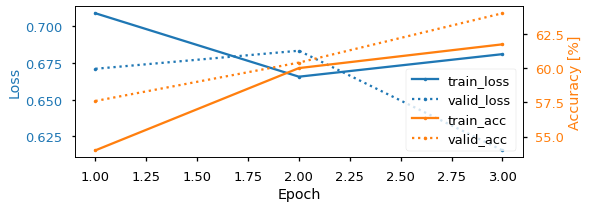

In [ ]:
# PLOTS
# Extract loss and balanced accuracy values for plotting from history object

df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()

In [ ]:
# CONFUSION MATRIX
# Switch to the test sampler

clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[169  59]
 [ 69 203]]
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.73       228
         1.0       0.77      0.75      0.76       272

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.75      0.74      0.74       500



---

## TEST AREA

---

In [ ]:
def print_dataset_lengths(datasets):
    for data in datasets:
        print(type(data))
        try:
            for i in range(100):
                print(f"({i}) length: {len(data)}  | 1st value: {data[0]} | type: {type(data)}")
                data = data[0]
        except:
            print("------------------------------------------------------------------")

In [ ]:
print_dataset_lengths([X.datasets, X])

<class 'list'>
(0) length: 1  | 1st value: <braindecode.datasets.base.BaseDataset object at 0x7f3f43aebf40> | type: <class 'list'>
(1) length: 2508001  | 1st value: (array([[ 8.11135531e-06],
       [-1.69963370e-06]]), None) | type: <class 'braindecode.datasets.base.BaseDataset'>
(2) length: 2  | 1st value: [[ 8.11135531e-06]
 [-1.69963370e-06]] | type: <class 'tuple'>
(3) length: 2  | 1st value: [8.11135531e-06] | type: <class 'numpy.ndarray'>
(4) length: 1  | 1st value: 8.11135531135531e-06 | type: <class 'numpy.ndarray'>
------------------------------------------------------------------
<class 'braindecode.datasets.sleep_physionet.SleepPhysionet'>
(0) length: 2508001  | 1st value: (array([[ 8.11135531e-06],
       [-1.69963370e-06]]), None) | type: <class 'braindecode.datasets.sleep_physionet.SleepPhysionet'>
(1) length: 2  | 1st value: [[ 8.11135531e-06]
 [-1.69963370e-06]] | type: <class 'tuple'>
(2) length: 2  | 1st value: [8.11135531e-06] | type: <class 'numpy.ndarray'>
(3) len

In [ ]:
# take only 1 3000ms window for both channels

window_index = 0

X = X_windowed.datasets[0][window_index][0]
X

Loading data for 1 events and 3000 original time points ...


array([[ 8.1113549e-06,  1.7488645e-05,  2.1239561e-05, ...,
        -1.0361905e-05, -1.1112088e-05, -2.1098901e-06],
       [-1.6996337e-06, -1.8915750e-06, -4.3868131e-06, ...,
         4.1172160e-07,  3.9626375e-06, -1.6036630e-06]], dtype=float32)

In [ ]:
# from braindecode.datasets.mne import create_from_mne_raw


# # attempt custom input
# X = mne.io.read_raw_fif('sleep_staging_dataset/0-raw.fif', preload=True)
# mne.io.Raw.filter(X, l_freq=None,h_freq=30, n_jobs=n_jobs)

# # preprocessing
# # preprocessors = [
# #     Preprocessor(lambda x: x * 1e6),
#     # Preprocessor('filter', l_freq=None, h_freq=30, n_jobs=n_jobs)
# # ]
# # preprocess(dataset, preprocessors)




Opening raw data file sleep_staging_dataset/0-raw.fif...
Isotrak not found
    Range : 2883000 ... 5391000 =  28830.000 ... 53910.000 secs
Ready.
Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 sec)



<Raw | 0-raw.fif, 2 x 2508001 (25080.0 s), ~38.3 MB, data loaded>

In [ ]:

# mapping = {  # We merge stages 3 and 4 following AASM standards.
#     'Sleep stage W': 0,
#     'Sleep stage 1': 1,
#     'Sleep stage 2': 2,
#     'Sleep stage 3': 3,
#     'Sleep stage 4': 3,
#     'Sleep stage R': 4
# }

# # Create windows
# window_size_samples = window_size_s * sfreq

# # define windows
# X_windowed = create_from_mne_raw(
#     X, trial_start_offset_samples=0, trial_stop_offset_samples=0,
#     window_size_samples=window_size_samples,
#     window_stride_samples=window_size_samples,
#     drop_last_window=True,
#     preload=True)

# # preprocess chanel-wise normalization
# # preprocess(windows_dataset, [Preprocessor(zscore)])

ValueError: All picks must be < n_channels (2), got 2

In [ ]:
dataset.datasets[0][3

(array([[ 1.01266568e+19],
        [-3.76343808e+18]]),
 None)

In [ ]:
# transform to a tensor and unsqueeze it
tt = to_tensor(X, device).unsqueeze(0)

# print(tt.shape)
# print(tt)

In [ ]:
# both channels
X_1 = X[0]
X_2 = X[1]

In [ ]:
# Get embedder from model and return the features
_model = clf.module_.emb
_model

SleepStagerChambon2018(
  (spatial_conv): Conv2d(1, 2, kernel_size=(2, 1), stride=(1, 1))
  (feature_extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(1, 13), stride=(1, 13), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=544, out_features=100, bias=True)
  )
)

In [ ]:
_model.return_feats = False
tt_y = _model.forward(tt)
y = tt_y.flatten().detach().numpy()

In [ ]:
_model.return_feats = True
tt_y_fr = _model.forward(tt)
y_fr = tt_y_fr.flatten().detach().numpy()

/home/maligan/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

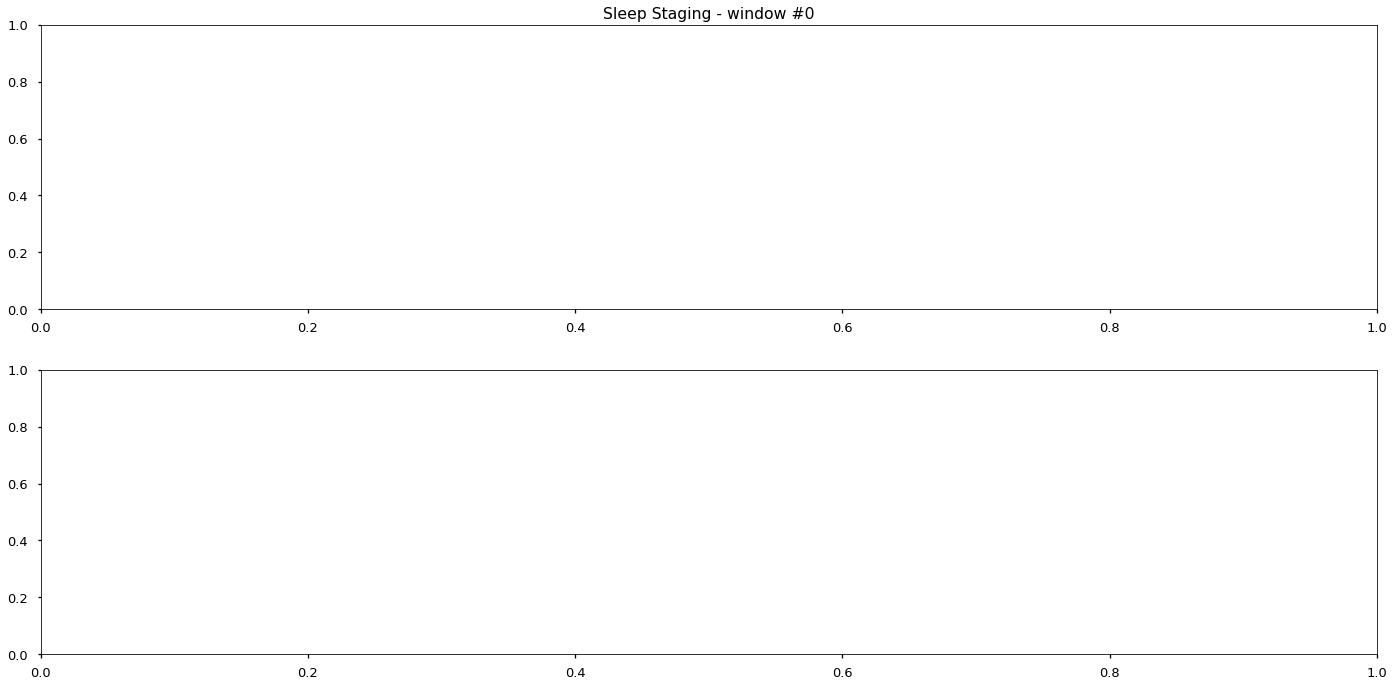

In [ ]:
# plot channels, y, y_fr

fig, ax = plt.subplots(2, figsize=(20,10))
fig.tight_layout(pad=3)


# plot all channels in the same plot
ax[0].set_title(f'Sleep Staging - window #{window_index}')
[ax[0].plot(x) for x in X]

# ax[1].set_title('predicted output - feature return (false)')
# ax[1].plot(y)
ax[1].set_title('predicted output - feature return (true)')
ax[1].plot(y_fr)

# create dir if it doesn't exist
plot_dir = './prediction_feature_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

plt.savefig(f'{plot_dir}/predicted_window_{window_index}.png')
# plt.close()


/home/maligan/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


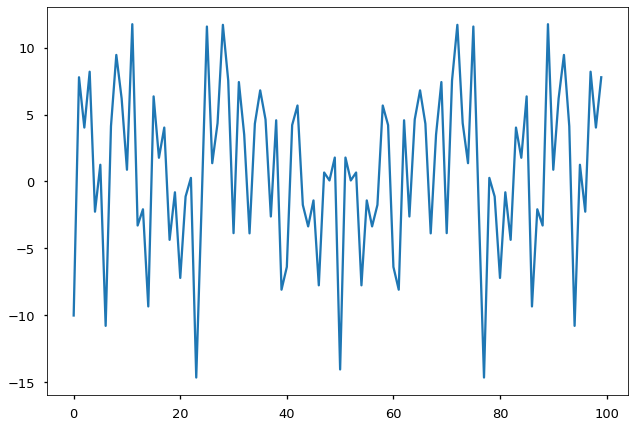

In [ ]:
plt.plot(np.fft.fft(y))

/home/maligan/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


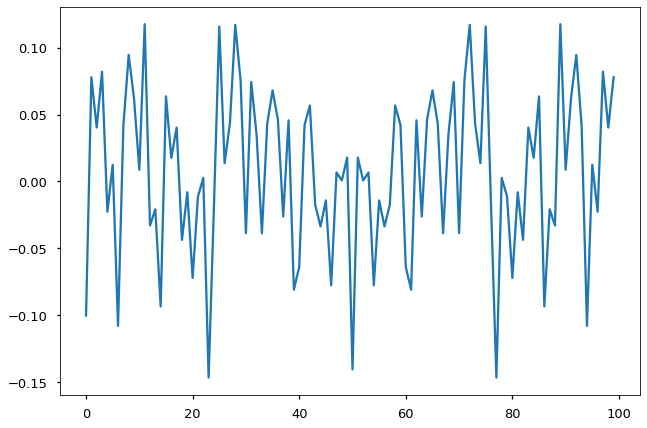

In [ ]:
plt.plot(np.fft.ifft(y))

---
# Save output
---

In [ ]:
### convert to csv for Robin's Viewer

import pandas as pd

# add time column
time = [x/100 for x in range(len(y))]
_y = np.expand_dims(y, 0)
_y = np.insert(_y, 0, time, axis=0)

df = pd.DataFrame(_y.T, columns=["Time", "model"]).set_index('Time')
df.to_csv("predictions_output.csv")

df

,model
Time,
0.00,0.746667
0.01,0.550015
0.02,0.478234
0.03,1.991932
0.04,0.466508
...,...
0.95,0.374336
0.96,-0.742403
0.97,0.385152
